# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.

2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [1]:
!pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes

## Downloading and becoming one with the data

In [2]:
# Get data (10% of 10 food classes from Food101) - https://www.kaggle.com/dansbecker/food-101
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2024-12-30 12:34:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.5MB/s    in 8.3s    

2024-12-30 12:34:25 (19.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback

* Model checkpoint with the ModelCheckpoint callback

* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [5]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [6]:
# Create TensorBoard callback (functionized beause we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving Tensorboard log files to: {log_dir}")
    return tensorboard_callback

## Creating models using Tensorflow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majroity of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

In [7]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [8]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_hub.keras_layer import KerasLayer

In [9]:
print(tf.__version__)
print(hub.__version__)

2.15.0
0.16.1


In [10]:
IMAGE_SHAPE + (3, )

(224, 224, 3)

In [11]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_lyaer",
                                           input_shape=IMAGE_SHAPE+(3,))

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [12]:
train_data_10_percent.num_classes

10

In [13]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [14]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_lyaer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [15]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [16]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2"
                                                                         )])

Saving Tensorboard log files to: tensorflow_hub/resnet50V2/20241230-123444
Epoch 1/5
24/24 [==============================] - 23s 627ms/step - loss: 1.7921 - accuracy: 0.4240 - val_loss: 1.1015 - val_accuracy: 0.6500
Epoch 2/5
24/24 [==============================] - 11s 477ms/step - loss: 0.8616 - accuracy: 0.7627 - val_loss: 0.7989 - val_accuracy: 0.7500
Epoch 3/5
24/24 [==============================] - 11s 476ms/step - loss: 0.6042 - accuracy: 0.8347 - val_loss: 0.7302 - val_accuracy: 0.7692
Epoch 4/5
24/24 [==============================] - 11s 479ms/step - loss: 0.4593 - accuracy: 0.8840 - val_loss: 0.6741 - val_accuracy: 0.7804
Epoch 5/5
24/24 [==============================] - 13s 566ms/step - loss: 0.3668 - accuracy: 0.9147 - val_loss: 0.6477 - val_accuracy: 0.7936


Wow!

That. Is. Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.

In [17]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

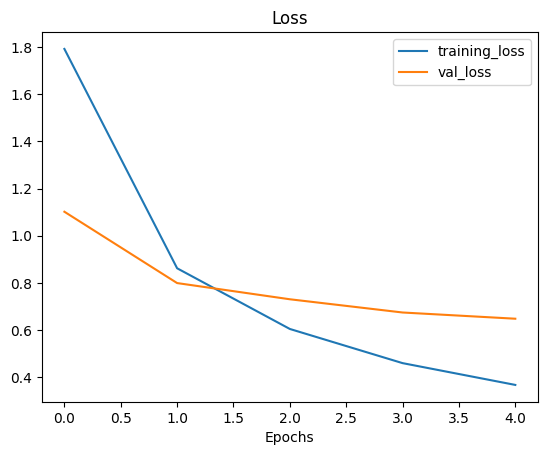

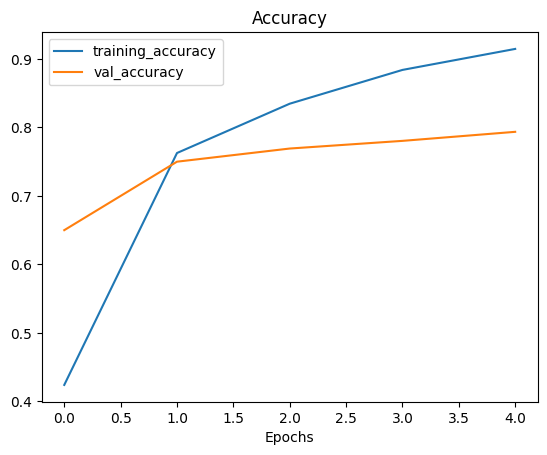

In [18]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [21]:
# Create EfficinetNetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficinetNetB0 model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Fit the EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving Tensorboard log files to: tensorflow_hub/efficientnetb0/20241230-124808
Epoch 1/5
24/24 [==============================] - 21s 520ms/step - loss: 1.8615 - accuracy: 0.4307 - val_loss: 1.2951 - val_accuracy: 0.7364
Epoch 2/5
24/24 [==============================] - 10s 450ms/step - loss: 1.0618 - accuracy: 0.7747 - val_loss: 0.8620 - val_accuracy: 0.8220
Epoch 3/5
24/24 [==============================] - 11s 462ms/step - loss: 0.7593 - accuracy: 0.8293 - val_loss: 0.6942 - val_accuracy: 0.8468
Epoch 4/5
24/24 [==============================] - 10s 433ms/step - loss: 0.6104 - accuracy: 0.8587 - val_loss: 0.6114 - val_accuracy: 0.8532
Epoch 5/5
24/24 [==============================] - 11s 487ms/step - loss: 0.5188 - accuracy: 0.8853 - val_loss: 0.5566 - val_accuracy: 0.8640


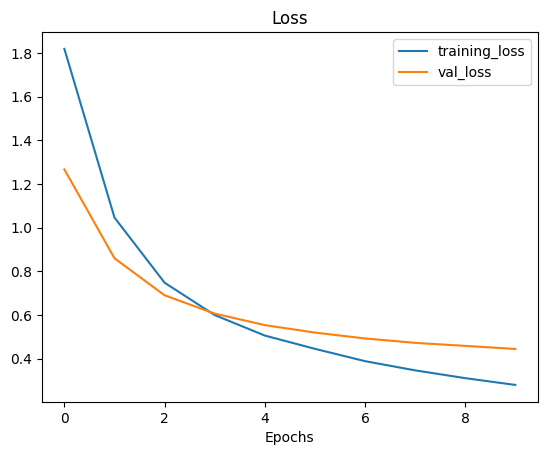

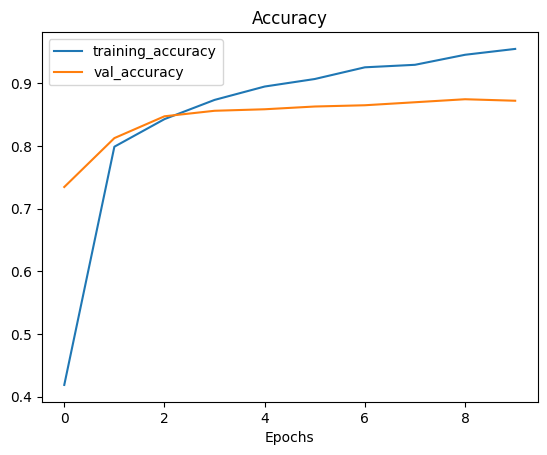

In [24]:
plot_loss_curves(efficientnet_history)